In [338]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, Activation, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

In [380]:
#importing csvs into a dataframe and looking at data
df_restock = pd.read_csv("Restock_data.csv")
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04 18:09:57.986537,USD,359.58
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06 15:19:35.630031,USD,344.69
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15 12:10:01.056616,USD,338.48
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24 15:04:48.844780,USD,43.08
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30 14:29:48.834370,USD,177.15


In [477]:
#importing into a dataframe and looking at data
df_inventory = pd.read_csv('Inventory_Turnover.csv')
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed
0,05d98e5c2603bf927952aa3eb74d1fc3,22-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20
1,05d98e5c2603bf927952aa3eb74d1fc3,21-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9
2,05d98e5c2603bf927952aa3eb74d1fc3,20-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15
3,05d98e5c2603bf927952aa3eb74d1fc3,19-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13
4,05d98e5c2603bf927952aa3eb74d1fc3,18-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24


In [478]:
#making a copy for future coding
df_inventory3 = df_inventory.copy()

In [434]:
#looking at info for data
df_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38982 entries, 0 to 38981
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sku            38982 non-null  object
 1   dispense_date  38982 non-null  object
 2   device_id      38982 non-null  object
 3   package_qty    38982 non-null  int64 
 4   qty_dispensed  38982 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


In [435]:
#converting date column to date type
df_inventory['dispense_date'] = df_inventory['dispense_date'].astype('datetime64[s]')
df_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38982 entries, 0 to 38981
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype        
---  ------         --------------  -----        
 0   sku            38982 non-null  object       
 1   dispense_date  38982 non-null  datetime64[s]
 2   device_id      38982 non-null  object       
 3   package_qty    38982 non-null  int64        
 4   qty_dispensed  38982 non-null  int64        
dtypes: datetime64[s](1), int64(2), object(2)
memory usage: 1.5+ MB


In [436]:
#making a copy for other analysis
df_inventory2 = df_inventory.copy()
df_restock2 = df_restock.copy()

In [437]:
#creating a new month column
df_inventory['month'] = df_inventory['dispense_date'].dt.month_name()
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February


In [438]:
#creating a new day column
df_inventory['day'] = df_inventory['dispense_date'].dt.day_name()
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month,day
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February,Thursday
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February,Wednesday
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February,Tuesday
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February,Monday
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February,Sunday


In [439]:
#creating a new column with the year
df_inventory['year'] = df_inventory['dispense_date'].dt.year
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month,day,year
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February,Thursday,2024
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February,Wednesday,2024
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February,Tuesday,2024
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February,Monday,2024
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February,Sunday,2024


In [440]:
#looking at info for data
df_restock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   device_id        722 non-null    object       
 1   global_order_id  722 non-null    object       
 2   restock_date     722 non-null    datetime64[s]
 3   currency_code    722 non-null    object       
 4   total            722 non-null    float64      
 5   month            722 non-null    object       
 6   day              722 non-null    object       
 7   year             722 non-null    int32        
dtypes: datetime64[s](1), float64(1), int32(1), object(5)
memory usage: 42.4+ KB


In [441]:
#converting restock date column to datetime type for better analysis, and removing time
df_restock['restock_date'] = pd.to_datetime(df_restock['restock_date'], errors='coerce')
df_restock['restock_date'] = df_restock['restock_date'].astype('datetime64[s]')

In [442]:
#making a copy for other analysis
df_restock2 = df_restock.copy()

In [443]:
#making sure dtype converted correctly
df_restock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   device_id        722 non-null    object       
 1   global_order_id  722 non-null    object       
 2   restock_date     722 non-null    datetime64[s]
 3   currency_code    722 non-null    object       
 4   total            722 non-null    float64      
 5   month            722 non-null    object       
 6   day              722 non-null    object       
 7   year             722 non-null    int32        
dtypes: datetime64[s](1), float64(1), int32(1), object(5)
memory usage: 42.4+ KB


In [444]:
#creating new column for month
df_restock['month'] = df_restock['restock_date'].dt.month_name()
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total,month,day,year
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04 18:09:57,USD,359.58,December,Monday,2023
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06 15:19:35,USD,344.69,November,Monday,2023
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15 12:10:01,USD,338.48,May,Monday,2023
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24 15:04:48,USD,43.08,January,Wednesday,2024
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30 14:29:48,USD,177.15,June,Friday,2023


In [445]:
#creating new column with day
df_restock['day'] = df_restock['restock_date'].dt.day_name()
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total,month,day,year
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04 18:09:57,USD,359.58,December,Monday,2023
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06 15:19:35,USD,344.69,November,Monday,2023
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15 12:10:01,USD,338.48,May,Monday,2023
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24 15:04:48,USD,43.08,January,Wednesday,2024
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30 14:29:48,USD,177.15,June,Friday,2023


In [446]:
#creating new column with year
df_restock['year'] = df_restock['restock_date'].dt.year
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total,month,day,year
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04 18:09:57,USD,359.58,December,Monday,2023
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06 15:19:35,USD,344.69,November,Monday,2023
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15 12:10:01,USD,338.48,May,Monday,2023
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24 15:04:48,USD,43.08,January,Wednesday,2024
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30 14:29:48,USD,177.15,June,Friday,2023


In [447]:
#looking at percentages for missing data
total = df_inventory.isnull().sum().sort_values(ascending=False)
percent = (df_inventory.isnull().sum()/df_inventory.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

               Total  Percent
sku                0      0.0
dispense_date      0      0.0
device_id          0      0.0
package_qty        0      0.0
qty_dispensed      0      0.0
month              0      0.0
day                0      0.0
year               0      0.0


In [448]:
#looking at percentages for missing data
total = df_restock.isnull().sum().sort_values(ascending=False)
percent = (df_restock.isnull().sum()/df_restock.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

                 Total  Percent
device_id            0      0.0
global_order_id      0      0.0
restock_date         0      0.0
currency_code        0      0.0
total                0      0.0
month                0      0.0
day                  0      0.0
year                 0      0.0


In [449]:
#looking for duplicates
df_restock.duplicated().value_counts()

False    722
Name: count, dtype: int64

In [450]:
#looking for duplicates
df_inventory.duplicated().value_counts()

False    38982
Name: count, dtype: int64

In [451]:
#average restocking cost
df_restock.describe()

,restock_date,total,year
count,722,722.000000,722.000000
mean,2023-10-04 11:55:16,272.511260,2023.252078
min,2023-03-24 15:34:41,5.090000,2023.000000
25%,2023-07-12 21:55:24,207.997500,2023.000000
50%,2023-10-06 16:59:48,271.385000,2023.000000
75%,2024-01-02 15:09:36,338.707500,2024.000000
max,2024-03-18 12:14:48,612.210000,2024.000000
std,NaN,101.077273,0.434507


In [452]:
#average qty_dispensed
df_inventory.describe()

,dispense_date,package_qty,qty_dispensed,year
count,38982,38982.000000,38982.000000,38982.000000
mean,2023-02-11 16:00:06,1.000487,8.145503,2022.614771
min,2022-01-03 00:00:00,1.000000,1.000000,2022.000000
25%,2022-08-03 00:00:00,1.000000,2.000000,2022.000000
50%,2023-02-04 00:00:00,1.000000,5.000000,2023.000000
75%,2023-08-16 00:00:00,1.000000,12.000000,2023.000000
max,2024-12-02 00:00:00,2.000000,162.000000,2024.000000
std,NaN,0.022072,9.055199,0.610529


In [453]:
#Group by sku and month
sku_cohort_analysis = df_inventory.groupby(['sku', 'month'])['qty_dispensed'].sum().unstack(level=-1).fillna(0)

# top of the SKU and devices
sku_cohort_analysis.head()

month,April,August,December,February,January,July,June,March,May,November,October,September
sku,,,,,,,,,,,,
01bdf04bb36dfcd94a9ef6fce31afc59,53.0,38.0,28.0,17.0,24.0,37.0,42.0,68.0,36.0,37.0,31.0,43.0
0294e9ff7bc77c29cdd83b6125ee4940,283.0,310.0,287.0,268.0,299.0,361.0,315.0,308.0,326.0,306.0,301.0,294.0
0300087aca6bca74aea4cfa71bbb5adb,475.0,448.0,568.0,404.0,454.0,425.0,364.0,477.0,496.0,548.0,516.0,441.0
033b262dad9e437f1864d875e073b328,118.0,70.0,86.0,69.0,68.0,78.0,128.0,101.0,93.0,123.0,76.0,70.0
05d98e5c2603bf927952aa3eb74d1fc3,876.0,1076.0,1285.0,801.0,944.0,1141.0,925.0,907.0,928.0,1142.0,1056.0,971.0


In [454]:
# group by device_id and month and display the top
device_cohort_analysis = df_inventory.groupby(['device_id', 'month'])['qty_dispensed'].sum().unstack(level=-1).fillna(0)

device_cohort_analysis.head()

month,April,August,December,February,January,July,June,March,May,November,October,September
device_id,,,,,,,,,,,,
device_0749c361d8ac7047c2f98fbcb2eadd16,4566,5637,5769,3905,4445,5897,5109,4652,5016,5478,4877,3437
device_65ae7ea424c57d46ac409256fe359349,5146,5817,6048,4392,5674,6009,5861,5822,5567,5992,5520,5893
device_6726f2a054f54836aaabe8c7643286bc,5165,6260,6955,4575,5332,6320,6055,5527,5339,6894,6287,5688
device_af645ebf4c96eb6e430529a2a9913686,4822,5287,5516,4088,4700,5115,5058,4766,4912,5534,4913,4857
device_c287be7e02167387bf9e7eca061ce5b5,5025,5315,5900,4450,5079,4932,4019,5252,4946,5445,5720,4951


In [455]:
#Group by sku and month
device_cohort_analysis_restock = df_restock.groupby(['device_id', 'month'])['total'].sum().unstack(level=-1).fillna(0)

# top of the SKU and devices
device_cohort_analysis_restock.head()

month,April,August,December,February,January,July,June,March,May,November,October,September
device_id,,,,,,,,,,,,
device_0749c361d8ac7047c2f98fbcb2eadd16,2159.46,2881.47,2971.81,2800.30,2756.06,3074.46,2731.66,2580.25,2758.07,2777.60,2487.85,2645.64
device_65ae7ea424c57d46ac409256fe359349,2946.12,3420.93,3202.41,2941.91,3431.36,3303.19,3562.66,3215.44,3496.40,3314.99,3547.70,3822.40
device_6726f2a054f54836aaabe8c7643286bc,2870.40,3569.80,4693.84,2670.01,3518.38,3959.48,3479.16,2902.56,3373.50,3877.77,3270.58,3133.02
device_af645ebf4c96eb6e430529a2a9913686,2904.29,4218.35,4620.00,3207.07,3880.38,3777.15,3897.02,3253.82,3311.21,4153.45,3791.04,3818.31
device_c287be7e02167387bf9e7eca061ce5b5,2931.09,2842.67,3109.80,3238.35,3577.10,3051.30,2833.00,3243.64,3212.52,3339.63,3472.87,2920.43


Looking at the top devices, they actually seem to be doing the same if not better throughout time. But the below graphs will look at the overall trend of all devices. 

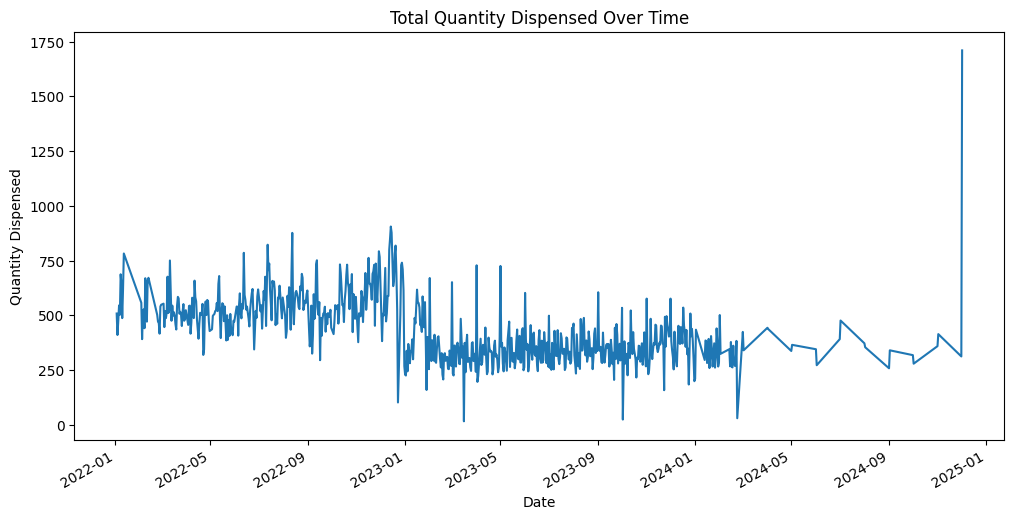

In [456]:
plt.figure(figsize=(12, 6))
df_inventory.groupby('dispense_date')['qty_dispensed'].sum().plot()
plt.title('Total Quantity Dispensed Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Dispensed')
plt.show()

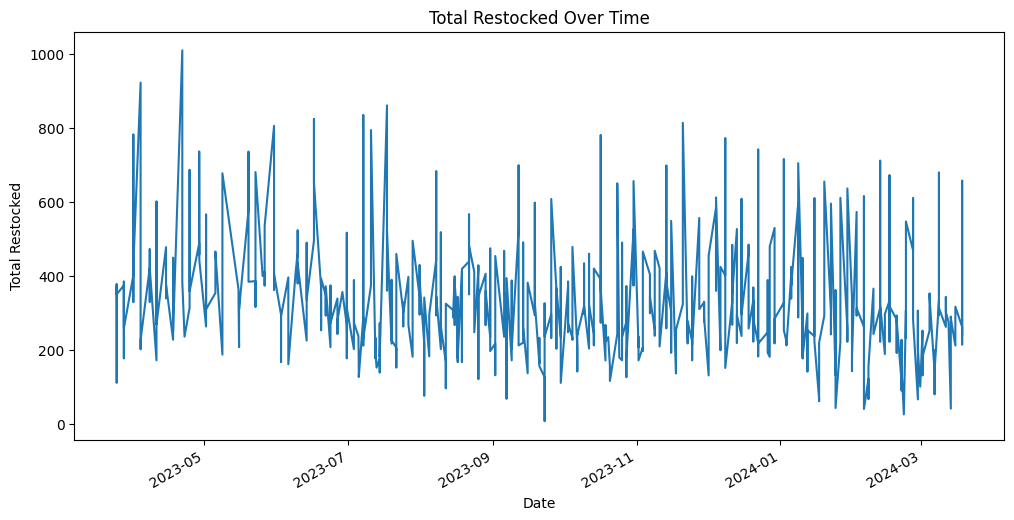

In [457]:
plt.figure(figsize=(12, 6))
df_restock.groupby('restock_date')['total'].sum().plot()
plt.title('Total Restocked Over Time')
plt.xlabel('Date')
plt.ylabel('Total Restocked')
plt.show()

The two above graph shows a trending downward quantity dispensed and resotcking amount. There does appear to be a spike in 2025 but we are unable to tell if that is a trend or just a random spike. ALso the activity in the total dispensed appears to be, overall, less frequent in late 2024/early 2025.  

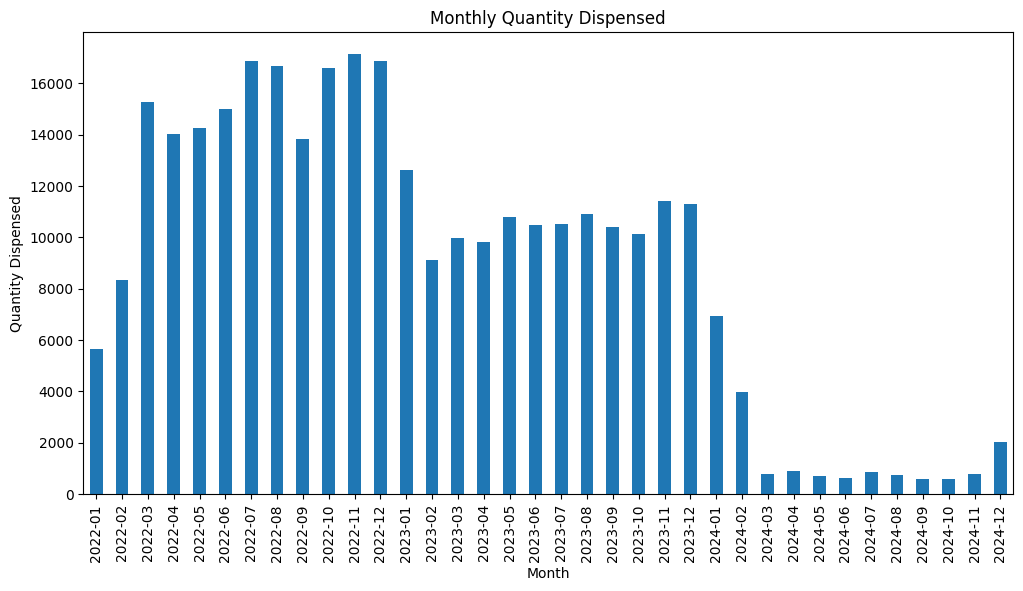

In [458]:
#Seasonal patterns
monthly_trend_i = df_inventory.groupby(df_inventory['dispense_date'].dt.to_period('M'))['qty_dispensed'].sum()
monthly_trend_i.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Quantity Dispensed')
plt.xlabel('Month')
plt.ylabel('Quantity Dispensed')
plt.show()

In [459]:
monthly_trend_i

dispense_date
2022-01     5666
2022-02     8333
2022-03    15275
2022-04    14020
2022-05    14269
2022-06    15005
2022-07    16867
2022-08    16668
2022-09    13843
2022-10    16584
2022-11    17135
2022-12    16859
2023-01    12633
2023-02     9120
2023-03     9978
2023-04     9822
2023-05    10807
2023-06    10478
2023-07    10537
2023-08    10920
2023-09    10383
2023-10    10134
2023-11    11433
2023-12    11306
2024-01     6931
2024-02     3957
2024-03      766
2024-04      882
2024-05      704
2024-06      619
2024-07      869
2024-08      728
2024-09      600
2024-10      599
2024-11      775
2024-12     2023
Freq: M, Name: qty_dispensed, dtype: int64

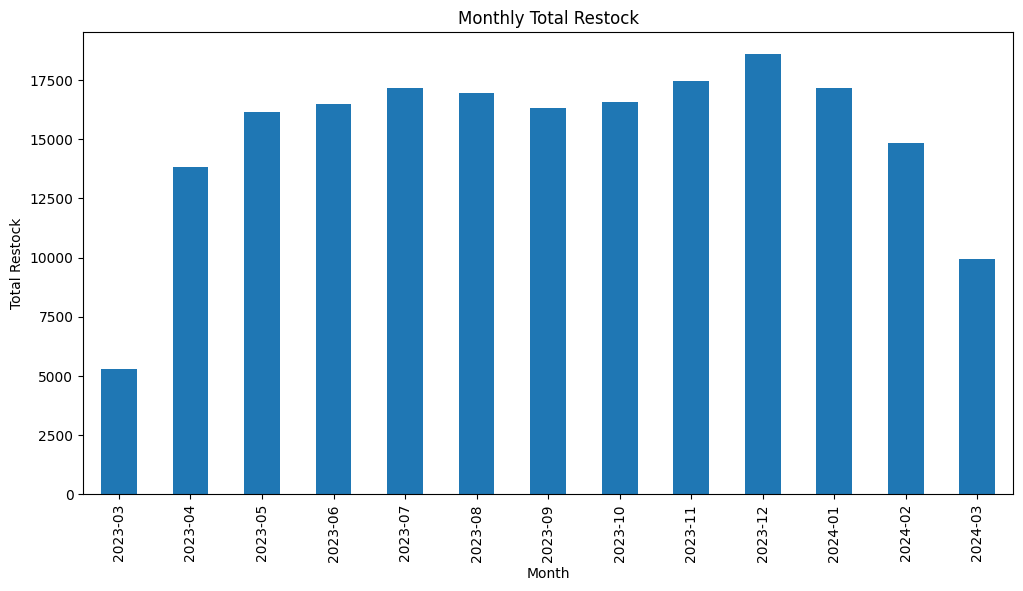

In [460]:
#Seasonal patterns
monthly_trend_r = df_restock.groupby(df_restock['restock_date'].dt.to_period('M'))['total'].sum()
monthly_trend_r.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Total Restock')
plt.xlabel('Month')
plt.ylabel('Total Restock')
plt.show()

In [461]:
monthly_trend_r

restock_date
2023-03     5272.56
2023-04    13811.36
2023-05    16151.70
2023-06    16503.50
2023-07    17165.58
2023-08    16933.22
2023-09    16339.80
2023-10    16570.04
2023-11    17463.44
2023-12    18597.86
2024-01    17163.28
2024-02    14857.64
2024-03     9923.15
Freq: M, Name: total, dtype: float64

Here is another chart that clearly shows the decreased amount of quantity dispensed by month. The restock data doesn't appear to go as far back in time as the inventory data so it may not be as accurate, since we're looking at a shorter time period. However, we should still be seeing some decrease. It doesn't make sense if more fewer items are getting bought, but the same number of items are still getting restocked. 

In [462]:
#grouping data
df_inventory2.set_index('dispense_date', inplace=True)
grouped_data = df_inventory2['qty_dispensed'].resample('ME').sum()
grouped_data = grouped_data.asfreq('ME')

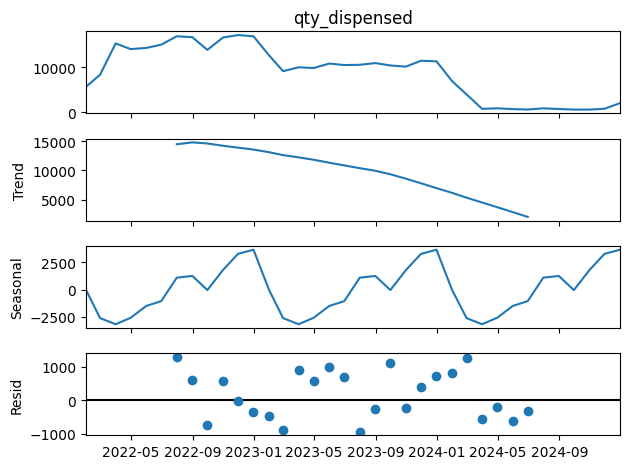

In [463]:
#checking seasonality trends
decomposition = seasonal_decompose(grouped_data, model='additive')
decomposition.plot()
plt.show()

The above chart shows trends over seasons. We can see that there is up up and down during the seasons, however there is still an overall downward trend in quantity dispensed. Unfortunately there was not enough data for me to repeat this on the restock dataset

<Axes: xlabel='restock_date', ylabel='total'>

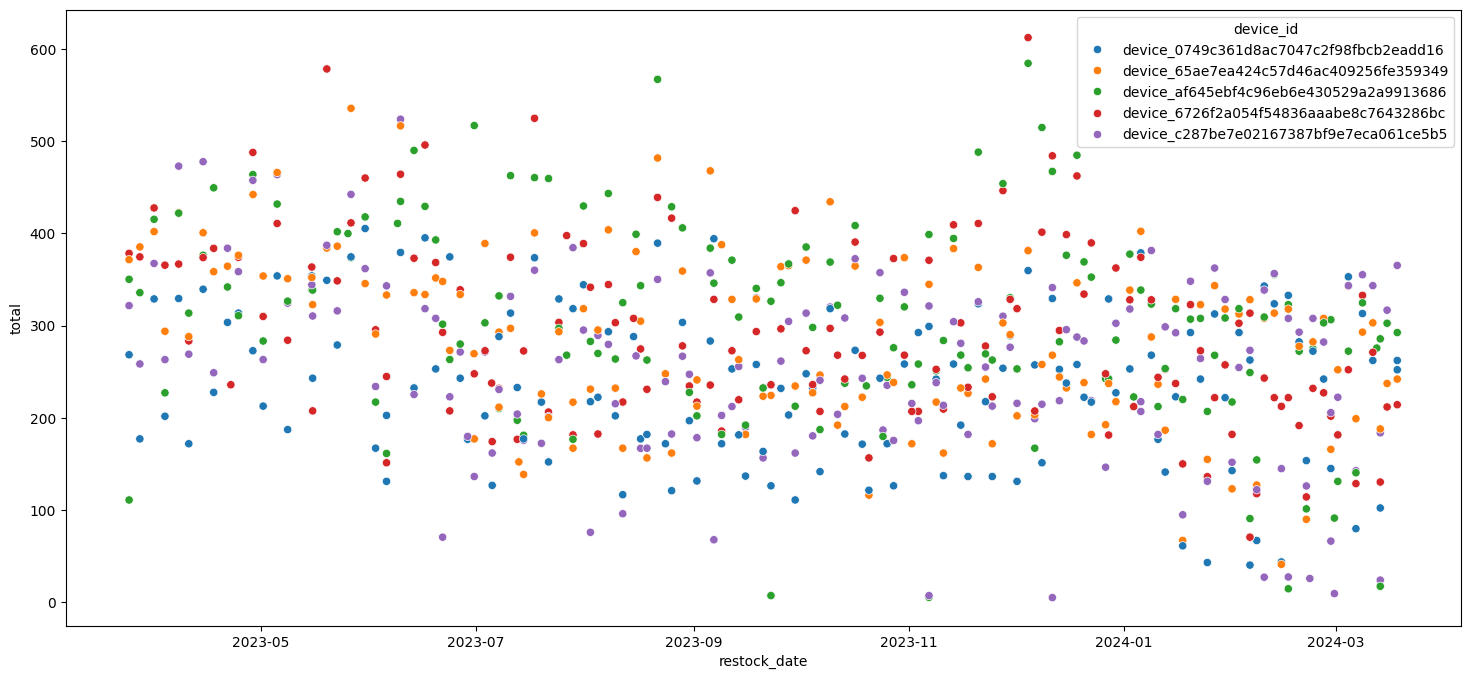

In [464]:
#looking to see if there's any correlation between the dates, device, and total amount
plt.figure(figsize=(18,8))
sns.scatterplot(data=df_restock, x="restock_date", y="total", hue="device_id")

<Axes: xlabel='dispense_date', ylabel='qty_dispensed'>

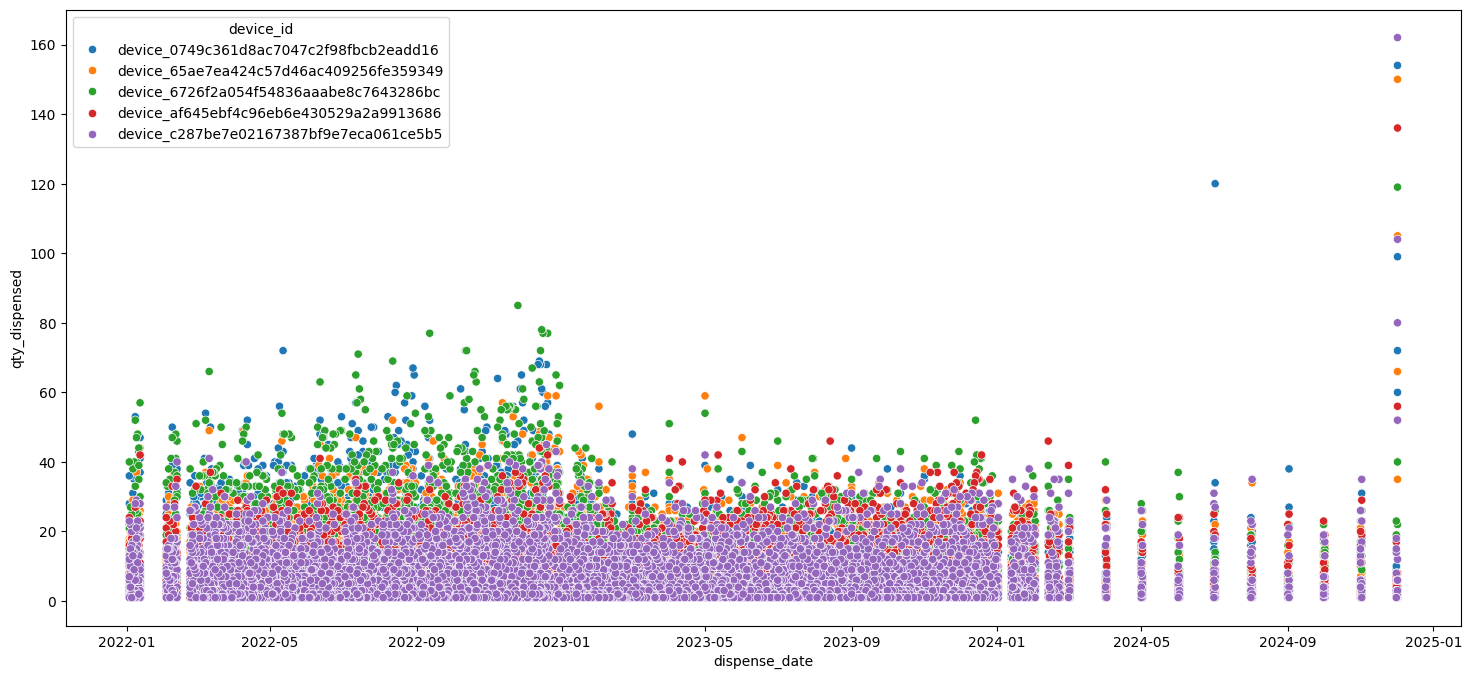

In [465]:
#looking to see if there's any correlation between the dates, device, and total amount
plt.figure(figsize=(18,8))
sns.scatterplot(data=df_inventory, x="dispense_date", y="qty_dispensed", hue="device_id")

The above restock graph shows every datapoint from the restock dataset. Here we can clearly see a downward trend in the restock quantities as well. It's not as extreme as the quantity dispensed but it is clear. I also created the same graph for the inventory quantity dispensed and it's harder to see, with all of this data, in this graph, the downward trend, but it is still there, except for the sudden spike in 2025. 

<Axes: xlabel='day', ylabel='qty_dispensed'>

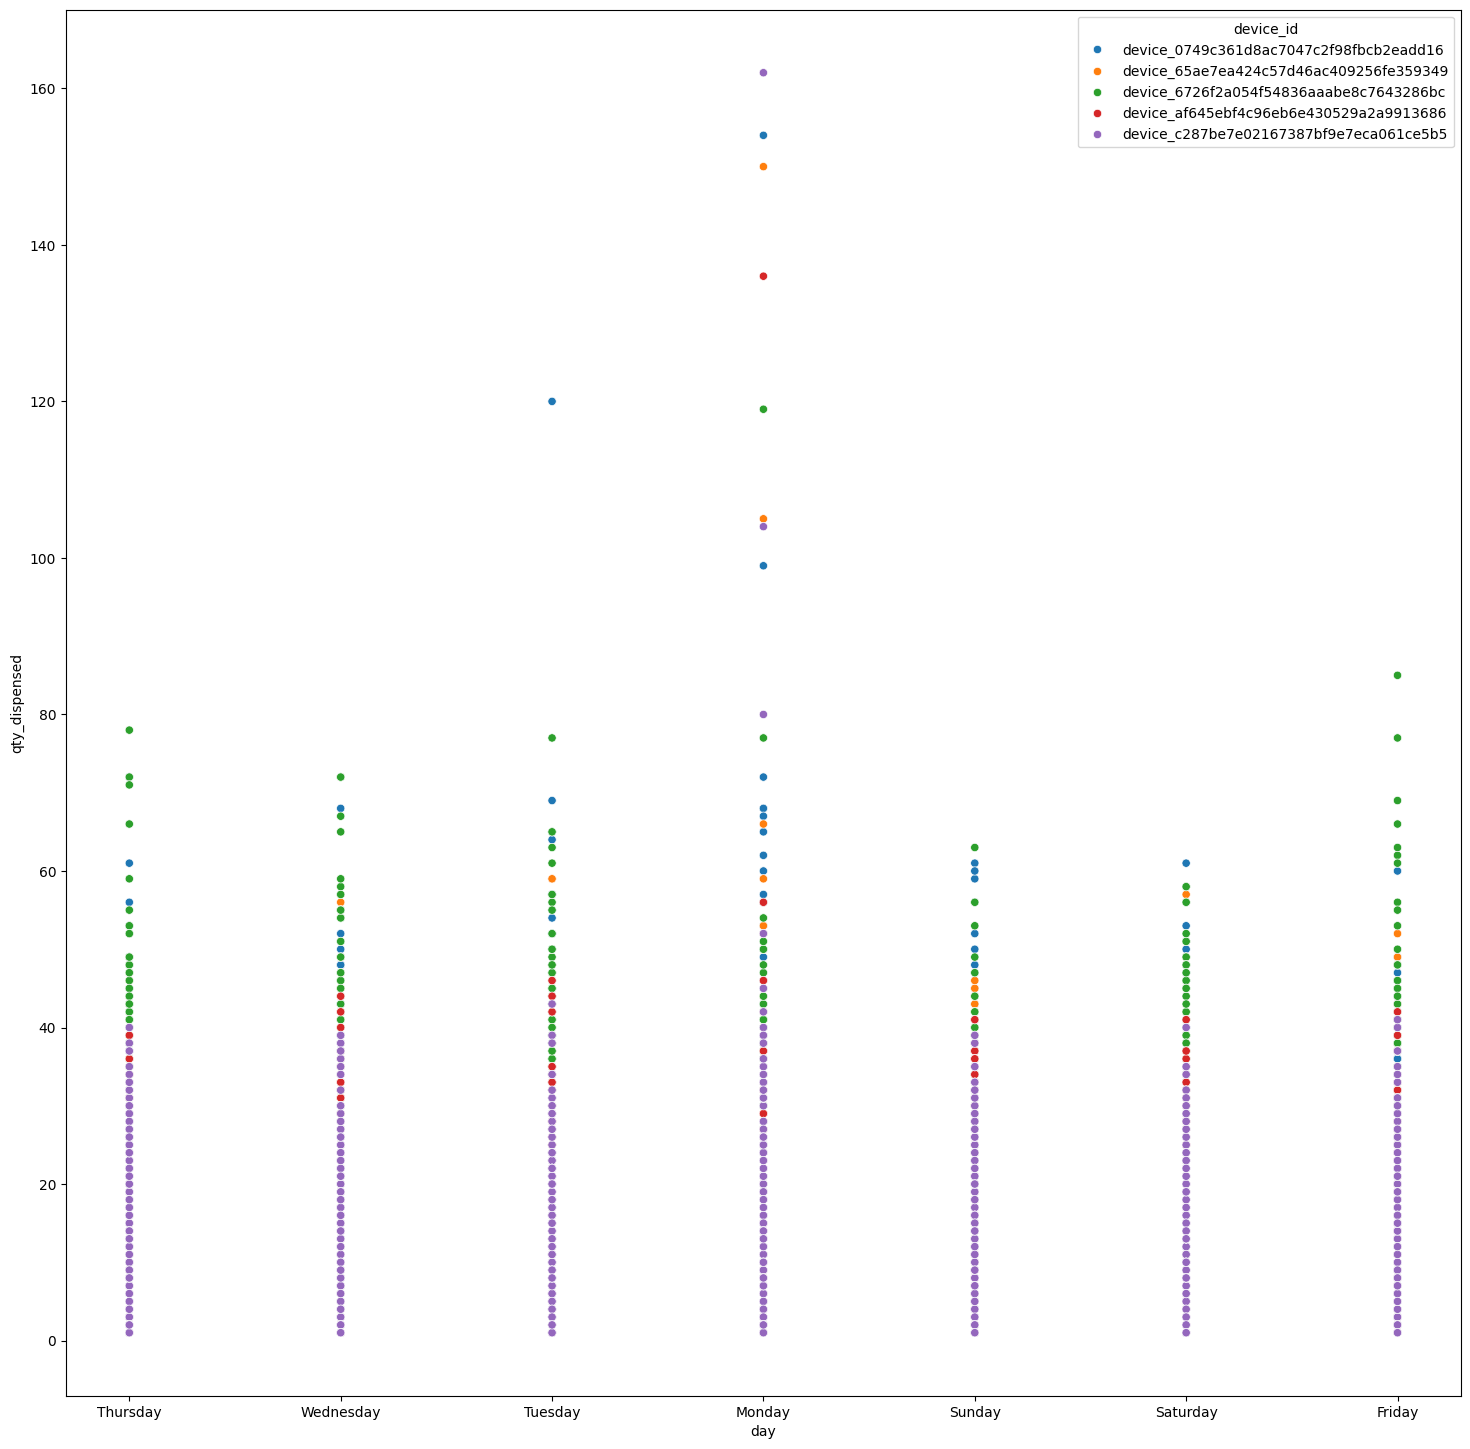

In [466]:
plt.figure(figsize=(18,18))
sns.scatterplot(data=df_inventory, x="day", y="qty_dispensed", hue="device_id")

<Axes: xlabel='day', ylabel='total'>

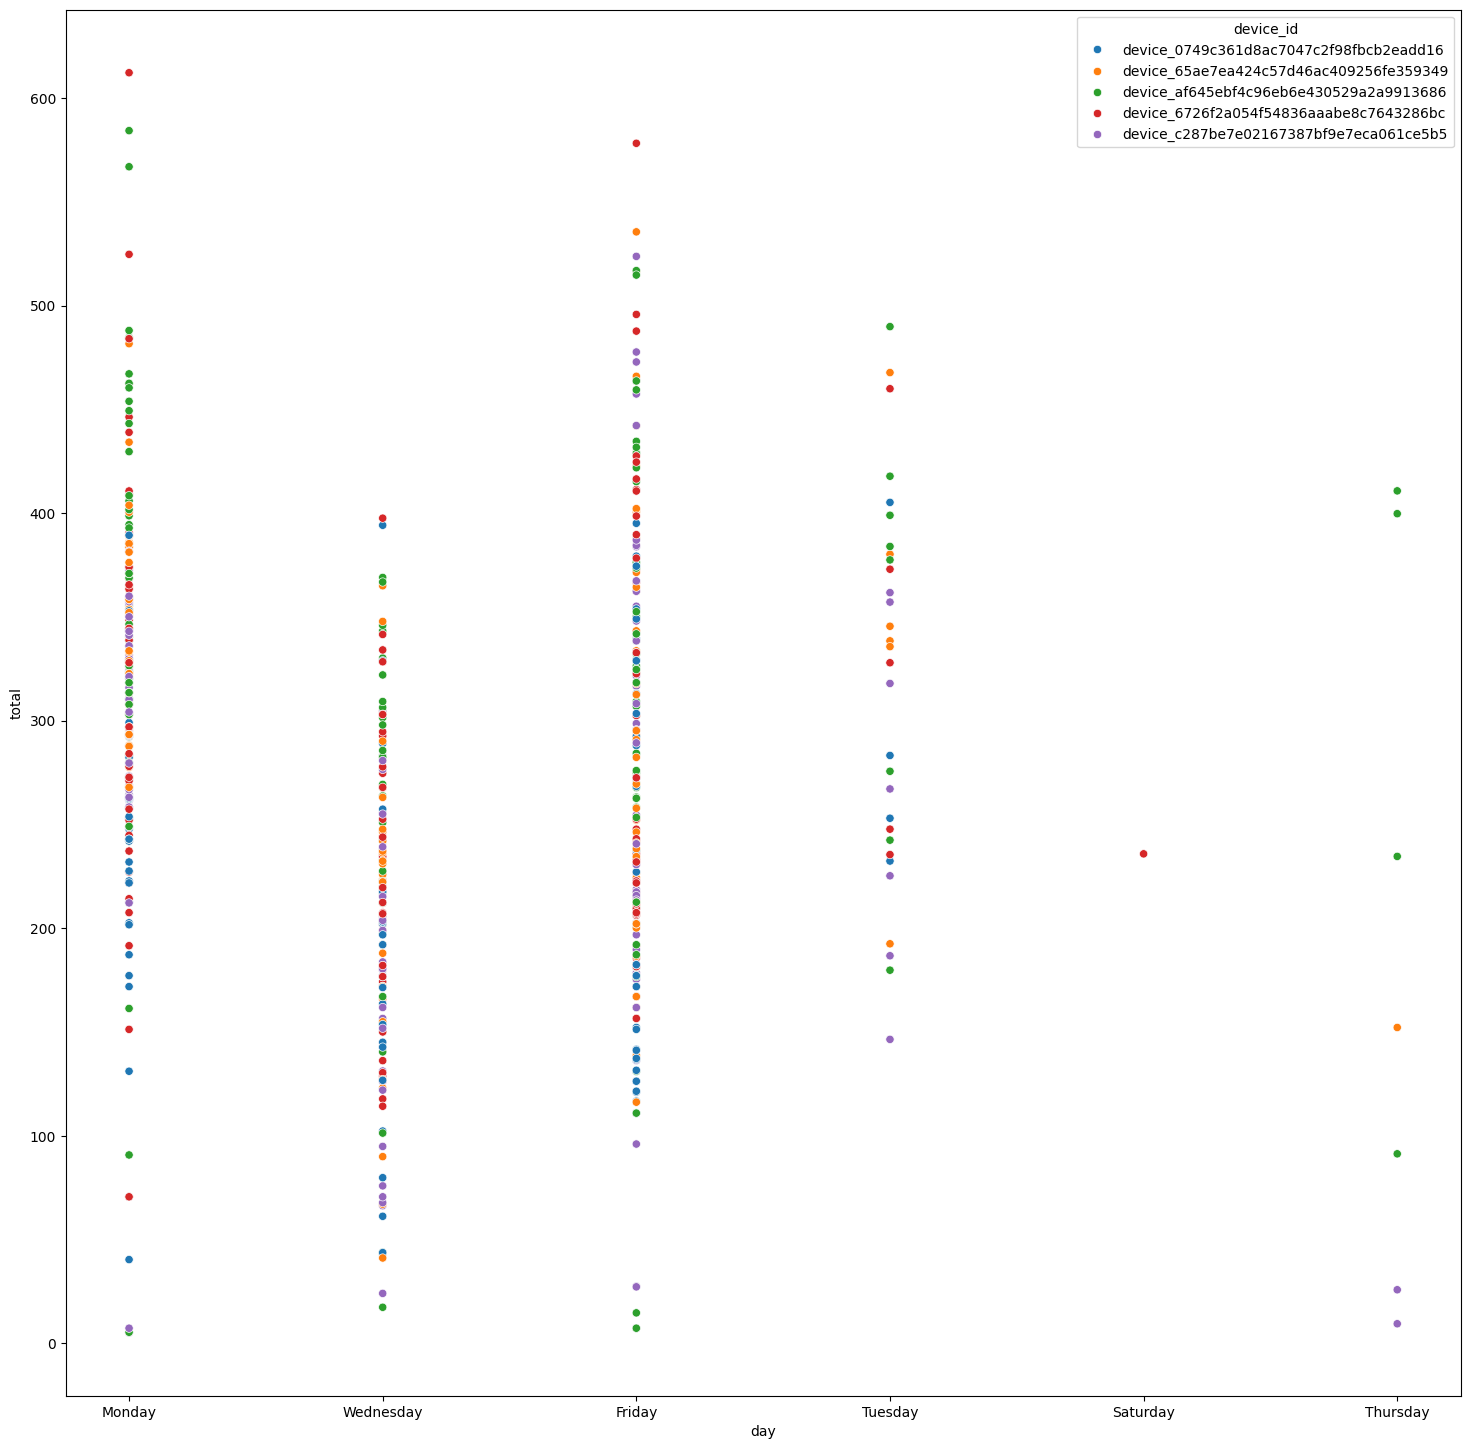

In [467]:
plt.figure(figsize=(18,18))
sns.scatterplot(data=df_restock, x="day", y="total", hue="device_id")

what we're seeing in the upper two graphs is the quantity dispensed and the restock of all of the machines. device c28 and 672 appear to be the ones that are most used and have the most quantity dispensed. Also, it appears that monday is the heaveiest day and therefore, a restock should probably happen on sunday, which does not exist, unless restock is early in the morning but, from looking at the data, it happens in the afternoon. Also, all machines appear to be restocked similarly when only two machines are getting the most traffic. But, we still need to look at other graphs. 

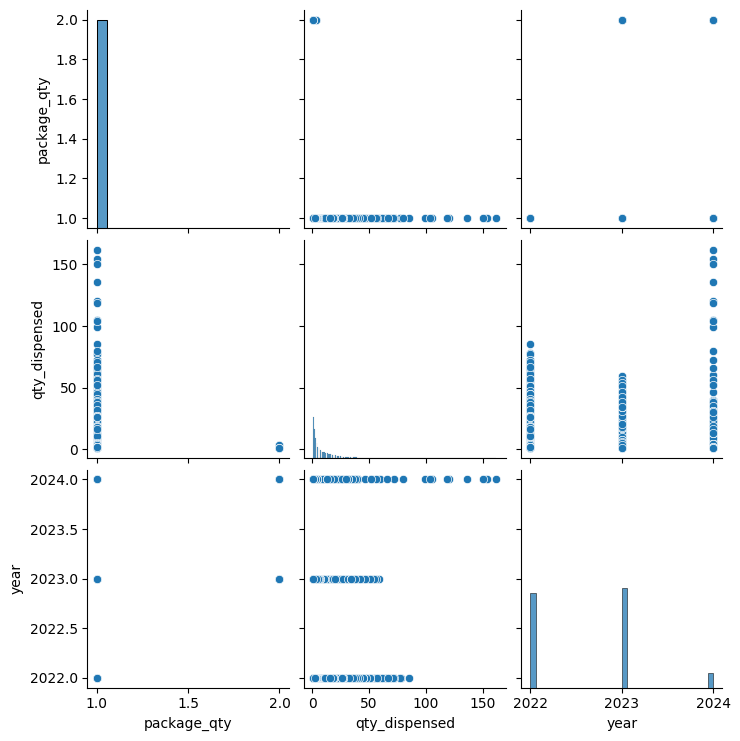

In [468]:
#pairplot of all numeric variables
sns.pairplot(df_inventory)
plt.show()

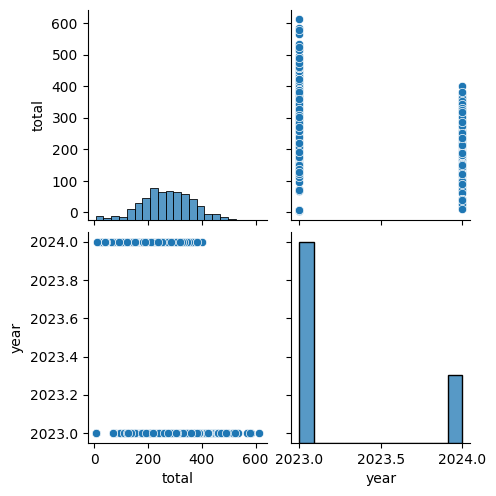

In [469]:
#pairplot of all numeric variables
sns.pairplot(df_restock)
plt.show()

Both of these above graphs group the data by year and we can clearly see the vast difference between 2023 adn 2024 in restocking and quantity dispensed

In [483]:
df_i2 = df_inventory3.copy()
df_r2 = df_restock.copy()

In [484]:
#splitting up date column
df_i2 = df_i2.set_index("dispense_date")
#df_i2['hour'] = df_i2.index.hour
df_i2['dayofweek'] = df_i2.index.dayofweek
df_i2['quarter'] = df_i2.index.quarter
df_i2['month'] = df_i2.index.month  
df_i2['year'] = df_i2.index.year
df_i2['dayofyear'] = df_i2.index.dayofyear
df_i2['dayofmonth'] = df_i2.index.day
df_i2['weekofyear'] = df_i2.index.isocalendar().week

In [485]:
#adding lags
target_map = df_i2['qty_dispensed'].to_dict()
df_i2['lag1'] = (df_i2.index - pd.Timedelta('7 days')).map(target_map)
df_i2['lag2'] = (df_i2.index - pd.Timedelta('14 days')).map(target_map)
df_i2['lag3'] = (df_i2.index - pd.Timedelta('30 days')).map(target_map)

In [479]:
# Convert 'dispense_date' to datetime if it's not already
df_inventory3['dispense_date'] = pd.to_datetime(df_inventory3['dispense_date'])

#df_inventory3.set_index('dispense_date', inplace=True)

# Initialize a dictionary to store forecasts
forecasts = {}

# Get unique SKUs
unique_skus = df_inventory3['sku'].unique()

C:\Users\brean\AppData\Local\Temp\ipykernel_19292\1960502315.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_inventory3['dispense_date'] = pd.to_datetime(df_inventory3['dispense_date'])


In [480]:
# Loop through each SKU
for sku in unique_skus:
    
    # Filter the DataFrame for the current SKU
    sku_data = df_inventory3[df_inventory3['sku'] == sku].copy()
    
    # Check if the DataFrame is empty
    if sku_data.empty:
        print(f"Warning: No data for SKU {sku}. Skipping this SKU.")
        continue  # Skip this SKU if no data
    
    # Print columns of the filtered DataFrame
    print(f"Columns in sku_data for SKU {sku}: {sku_data.columns}")
    
    # Strip leading/trailing whitespace from column names (if any)
    sku_data.columns = sku_data.columns.str.strip()
    
    # Check again for the 'dispense_date' column
    if 'dispense_date' not in sku_data.columns:
        print(f"Error: 'dispense_date' column missing for SKU {sku}. Skipping this SKU.")
        continue  # Skip this SKU if the column is missing
    
    # Ensure the data is sorted by date
    sku_data.sort_values('dispense_date', inplace=True)
    
    # Ensure dispense_date is a datetime type
    sku_data['dispense_date'] = pd.to_datetime(sku_data['dispense_date'], errors='coerce')
    
    # Set dispense_date as the index
    sku_data.set_index('dispense_date', inplace=True)
    
    # Aggregate quantities by day in case of multiple entries per day
    daily_totals = sku_data['qty_dispensed'].resample('D').sum()
    
    # Coerce errors to NaN and drop NaNs
    daily_totals = pd.to_numeric(daily_totals, errors='coerce').dropna()

    if daily_totals.empty:
        print(f"No data available for SKU {sku} - ARIMA model fitting skipped.")
    else:
        print(f"Data for SKU {sku}:")
        print(daily_totals.head())  # Check the first few rows
        
        # Check the length of the series
        if len(daily_totals) < 2:
            print(f"Not enough data for SKU {sku} - ARIMA model fitting skipped.")
        else:
            # Define and fit the ARIMA model
            model = ARIMA(daily_totals, order=(1, 1, 1))  # Example order, adjust based on ACF/PACF plots or auto-arima
            try:
                model_fit = model.fit()
                
                # Forecast the next 7 days
                forecast = model_fit.forecast(steps=7)
                
                # Store the forecast in the dictionary
                forecasts[sku] = forecast
            except Exception as e:
                print(f"Error fitting ARIMA model for SKU {sku}: {e}")

# Optional: print forecasts to check the output
print(forecasts)


Columns in sku_data for SKU 05d98e5c2603bf927952aa3eb74d1fc3: Index(['sku', 'dispense_date', 'device_id', 'package_qty', 'qty_dispensed'], dtype='object')
Data for SKU 05d98e5c2603bf927952aa3eb74d1fc3:
dispense_date
2022-02-23    17
2022-02-24    18
2022-02-25    12
2022-02-26    19
2022-02-27    13
Freq: D, Name: qty_dispensed, dtype: int64
Columns in sku_data for SKU 30ab8e0c136827fb3fd120a2ece62897: Index(['sku', 'dispense_date', 'device_id', 'package_qty', 'qty_dispensed'], dtype='object')
Data for SKU 30ab8e0c136827fb3fd120a2ece62897:
dispense_date
2022-02-23    4
2022-02-24    2
2022-02-25    3
2022-02-26    5
2022-02-27    6
Freq: D, Name: qty_dispensed, dtype: int64
Columns in sku_data for SKU 6049baba09d0c82b678cf212f8c3d66b: Index(['sku', 'dispense_date', 'device_id', 'package_qty', 'qty_dispensed'], dtype='object')
Data for SKU 6049baba09d0c82b678cf212f8c3d66b:
dispense_date
2022-02-23    5
2022-02-24    5
2022-02-25    2
2022-02-26    4
2022-02-27    5
Freq: D, Name: qty_di

C:\Users\brean\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Columns in sku_data for SKU 4a37f2a01e5bcb8047c22d426ace10f3: Index(['sku', 'dispense_date', 'device_id', 'package_qty', 'qty_dispensed'], dtype='object')
Data for SKU 4a37f2a01e5bcb8047c22d426ace10f3:
dispense_date
2022-02-24    1
2022-02-25    1
2022-02-26    1
2022-02-27    1
2022-02-28    1
Freq: D, Name: qty_dispensed, dtype: int64
Columns in sku_data for SKU 55a9483712810e661fa83bbeb780d8ba: Index(['sku', 'dispense_date', 'device_id', 'package_qty', 'qty_dispensed'], dtype='object')
Data for SKU 55a9483712810e661fa83bbeb780d8ba:
dispense_date
2022-02-23    1
2022-02-24    0
2022-02-25    0
2022-02-26    2
2022-02-27    1
Freq: D, Name: qty_dispensed, dtype: int64
Columns in sku_data for SKU 66133559e0f832da8500b2127d18f9dc: Index(['sku', 'dispense_date', 'device_id', 'package_qty', 'qty_dispensed'], dtype='object')
Data for SKU 66133559e0f832da8500b2127d18f9dc:
dispense_date
2022-02-23    2
2022-02-24    0
2022-02-25    0
2022-02-26    0
2022-02-27    2
Freq: D, Name: qty_dispens

In [481]:
# At this point, `forecasts` contains the 7-day forecasts for each SKU
# Let's print the forecast for the first SKU to demonstrate
first_sku = list(forecasts.keys())[0]
print(f"Forecasts for SKU {first_sku}:")
print(forecasts[first_sku])


Forecasts for SKU 05d98e5c2603bf927952aa3eb74d1fc3:
2024-02-23    18.764417
2024-02-24    18.559475
2024-02-25    18.525482
2024-02-26    18.519844
2024-02-27    18.518909
2024-02-28    18.518754
2024-02-29    18.518728
Freq: D, Name: predicted_mean, dtype: float64


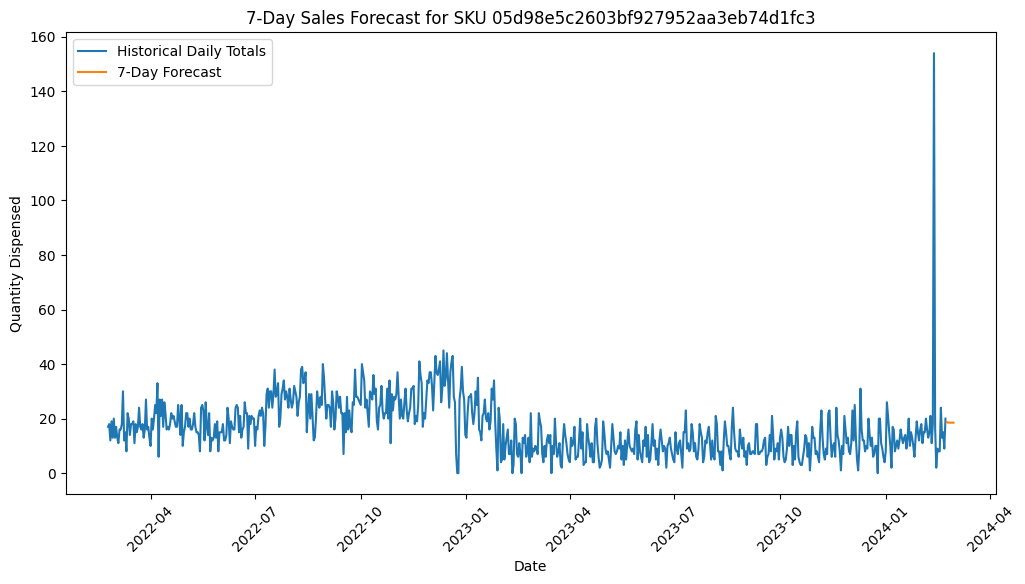

In [487]:

# Select the SKU for visualization (replace 'first_sku' with your specific SKU if needed)
sku_to_visualize = '05d98e5c2603bf927952aa3eb74d1fc3'

# Get the historical data for the selected SKU
historical_data = df_i2[df_i2['sku'] == sku_to_visualize].copy()
historical_data.sort_values('dispense_date', inplace=True)
#historical_data.set_index('dispense_date', inplace=True)
daily_totals_historical = historical_data['qty_dispensed'].resample('D').sum()

# Get the forecast data for the selected SKU
forecast_data = forecasts[sku_to_visualize]

# Plot the historical data
plt.figure(figsize=(12, 6))
plt.plot(daily_totals_historical.index, daily_totals_historical, label='Historical Daily Totals')

# Plot the forecast data
forecast_dates = [daily_totals_historical.index[-1] + timedelta(days=i) for i in range(1, 8)]
plt.plot(forecast_dates, forecast_data, label='7-Day Forecast')

plt.title(f"7-Day Sales Forecast for SKU {sku_to_visualize}")
plt.xlabel("Date")
plt.ylabel("Quantity Dispensed")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [488]:
#caclulating for 1 sku
inventory_data_test = df_i2[df_i2['sku'] == '05d98e5c2603bf927952aa3eb74d1fc3']
max_daily_dispense = int(inventory_data_test['qty_dispensed'].max())
max_lead_time = 7 #considered 14 days for this example


safety_stock = max_daily_dispense * max_lead_time
print('Safety stock for next 7 days is:',safety_stock)

forecast_demand = int(forecast_data.sum())

min_level = forecast_demand + safety_stock
print('Min level for next 7 days is:',min_level)

standard_deviation = df_i2['qty_dispensed'].std()

max_level = min_level + standard_deviation
print('Max level for next 7 days is:',max_level)

Safety stock for next 7 days is: 1078
Min level for next 7 days is: 1207
Max level for next 7 days is: 1216.0551991620207
